# ASSIGNMENT 2: MovieLens Dataset.

The dataset describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. In this project we use standard (latest) version of the MovieLens dataset. As in the previous assignmnet we will analyzie and explore the data, then we will pre-process the data and build a rule based and clustering based recommender system. Our steps:

1. Analyzing and Exploring the data.
2. Pre-processing.
3. Clustering.
4. Rule based system.
5. Accuracy.


### 01. Analyzing and Exploring the data - movie lens dataset.

##### 🧾 **step 1: information about number of movies and number of users**


In [2]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import recommendation as rec
from mlxtend.frequent_patterns import apriori
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 1.0 GB


In [6]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [9]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [10]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

Number of ratings: 33832162
Number of unique movieId's: 83239
Number of unique users: 330975


##### 📽️ **step 2: distribution of movie ratings**

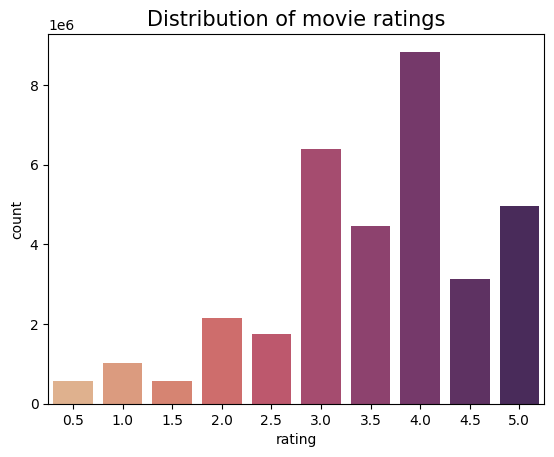

In [11]:
sns.countplot(x="rating", data = ratings, palette = "flare", hue="rating",legend=False)
plt.title("Distribution of movie ratings", fontsize = 15)
plt.show()

##### 📈 **step 3: most frequently rated movies**

In [12]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [13]:
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")
genre_frequency

There are 20 genres.


Counter({'Drama': 33681,
         'Comedy': 22830,
         'Thriller': 11675,
         'Romance': 10172,
         'Action': 9563,
         'Documentary': 9283,
         'Horror': 8570,
         '(no genres listed)': 7060,
         'Crime': 6917,
         'Adventure': 5349,
         'Sci-Fi': 4850,
         'Animation': 4579,
         'Children': 4367,
         'Mystery': 3972,
         'Fantasy': 3821,
         'War': 2301,
         'Western': 1690,
         'Musical': 1059,
         'Film-Noir': 354,
         'IMAX': 195})

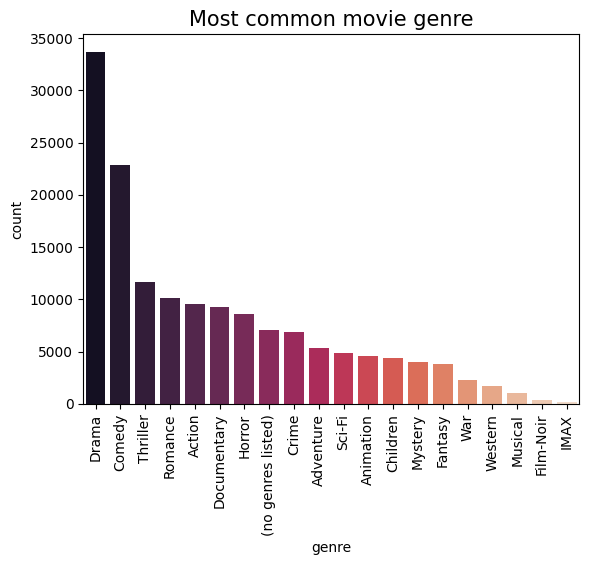

In [14]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', hue= "genre", data=genre_frequency_df.sort_values(by='count', ascending=False), palette="rocket")
plt.xticks(rotation=90)
plt.title("Most common movie genre", fontsize = 15)
plt.show()

### 02. Data Pre-processing.

We want to use apriori algorithm and clustering methods to improve our recomendation system. Before that - there is a need to clean the dataset and prepare new datasets.

##### 🧹 **step 1: cleaning dataset:** 
- _genres_ was expressed as a string with a pipe | separating each genre. We wanted to delete this pipe - we created a list instead.
- _title_ we cannot extract year of the movie from the title, because some names of the movie repeat.

- divide genres into zero's and one's if given movie has a label of given genre

In [15]:
unique_genres = set(g for genres in movies['genres'] for g in genres)

for genre in unique_genres:
    movies[genre] = movies.genres.transform(lambda x: int(genre in x))

- _timestamp_ to delete, because it  won't help with recommendation system

In [16]:
del ratings['timestamp']

In [17]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


- _genres_ to delete, because we change the movie table

In [18]:
del movies['genres']

In [19]:
movies.head()

,movieId,title,Crime,(no genres listed),Romance,Documentary,Fantasy,Action,Animation,Western,...,Adventure,Mystery,Drama,Comedy,War,Horror,Sci-Fi,Musical,Children,Thriller
0,1,Toy Story (1995),0,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,2,Jumanji (1995),0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


- movie_kmeans used in KMeans method

In [20]:
movies_kmeans = movies.drop(columns = ['title'])

In [21]:
movies_kmeans.head()

,movieId,Crime,(no genres listed),Romance,Documentary,Fantasy,Action,Animation,Western,Film-Noir,...,Adventure,Mystery,Drama,Comedy,War,Horror,Sci-Fi,Musical,Children,Thriller
0,1,0,0,0,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,2,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,3,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


##### 🍀 **step 2: shrinking the dataset**

📌 **note:** our datset is too big to hande - there are many methods to deal with that problem. We chose:
- **data shrinking: by choosing the users who like maximum number of movies**
- **our hypothesis:** we assume that users who rate the movies most often are the most important ones in recomendation system, that's why we take 2000 best of them


➕ top 10 visualization: {only visualization for raport}

In [22]:
top_10 = rec.shrinking_data(10, ratings)
top_10

,userId,movieId,rating
0,48766,1,3.5
1,48766,2,1.5
2,48766,3,3.0
3,48766,4,1.0
4,48766,5,2.5
...,...,...,...
107374,236260,92643,4.0
107375,236260,93116,3.0
107376,236260,93838,4.5
107377,236260,99114,3.0


In [23]:
top_10_final = top_10.groupby('userId')['movieId'].count()
top_10_final

userId
48766      9554
76618      8919
175998     9016
184775     7535
189614    33332
207216     9178
214831     7266
230765     7719
233891     7372
236260     7488
Name: movieId, dtype: int64

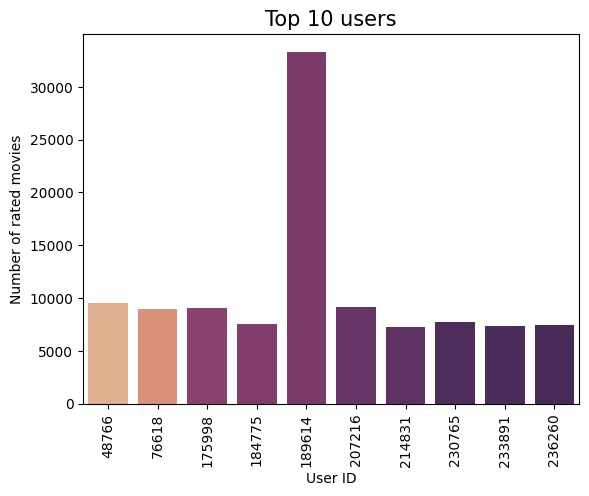

In [24]:
top_10_final_df = top_10_final.reset_index()
top_10_final_df.columns = ['userId', 'count']

sns.barplot(x='userId', y='count', hue='userId', 
            data=top_10_final_df.sort_values(by='count', ascending=False), 
            palette="flare", legend=False)

plt.xticks(rotation=90)
plt.title("Top 10 users", fontsize=15)
plt.xlabel('User ID')
plt.ylabel('Number of rated movies')
plt.show()

➕ important shrinking

In [25]:
shrinked_ratings = rec.shrinking_data(2000, ratings)

In [26]:
shrinked_ratings.shape

(4015502, 3)

In [27]:
shrinked_ratings[['userId', 'movieId', 'rating']]

,userId,movieId,rating
0,149,1,4.0
1,149,2,2.5
2,149,3,0.5
3,149,5,2.5
4,149,7,2.0
...,...,...,...
4015497,330914,267456,4.5
4015498,330914,269638,2.0
4015499,330914,270350,4.0
4015500,330914,275669,3.5


##### 🚀 **step 2: merging the dataset**

In [28]:
movie_data = shrinked_ratings.merge(movies, on='movieId')

In [29]:
movie_data.head()

,userId,movieId,rating,title,Crime,(no genres listed),Romance,Documentary,Fantasy,Action,...,Adventure,Mystery,Drama,Comedy,War,Horror,Sci-Fi,Musical,Children,Thriller
0,149,1,4.0,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,305,1,5.0,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,461,1,4.5,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
3,487,1,4.5,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
4,897,1,4.0,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0


In [30]:
movie_data.shape

(4015502, 24)

In [31]:
movie_data['title'].value_counts()[0:10]

title
Matrix, The (1999)                                                                1946
Silence of the Lambs, The (1991)                                                  1918
Pulp Fiction (1994)                                                               1917
Back to the Future (1985)                                                         1912
Forrest Gump (1994)                                                               1911
Star Wars: Episode IV - A New Hope (1977)                                         1899
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    1894
Jurassic Park (1993)                                                              1888
Sixth Sense, The (1999)                                                           1886
Shawshank Redemption, The (1994)                                                  1883
Name: count, dtype: int64

##### 🎯 **step 3: splitting the raitings dataset** 
- we use **cross validation** which is technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data to use it in Kmeans (clustering) later on
- **KFold** explanation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- after cross validation we use combine_datasets() method to combine all train sets and test sets in two separate dataframes

**step 3.1 : KFold split - cross validation**

In [32]:
kf = KFold(n_splits = 5, shuffle = True, random_state=42)

In [33]:
train_df, test_df = rec.return_datasets(movie_data, kf)

In [34]:
for i in range(len(train_df)):
    print(f"Fold {i+1}")
    print("Train Data:")
    print(train_df[i].head())
    print(train_df[i].shape)
    print("Test Data:")
    print(test_df[i].head())
    print(test_df[i].shape)
    print("\n")

Fold 1
Train Data:
   userId  movieId  rating             title  Crime  (no genres listed)  \
0     149        1     4.0  Toy Story (1995)      0                   0   
1     305        1     5.0  Toy Story (1995)      0                   0   
3     487        1     4.5  Toy Story (1995)      0                   0   
4     897        1     4.0  Toy Story (1995)      0                   0   
5    1109        1     5.0  Toy Story (1995)      0                   0   

   Romance  Documentary  Fantasy  Action  ...  Adventure  Mystery  Drama  \
0        0            0        1       0  ...          1        0      0   
1        0            0        1       0  ...          1        0      0   
3        0            0        1       0  ...          1        0      0   
4        0            0        1       0  ...          1        0      0   
5        0            0        1       0  ...          1        0      0   

   Comedy  War  Horror  Sci-Fi  Musical  Children  Thriller  
0       1  

### 03. Clustering based recommender system.

Movie recommendations system based on K-means. 

##### 🌺 **step 1: calculating how many k is needed**

Let's plot the graph using **elbow method** - graphical method for finding the optimal K value in a k-means clustering algorithm. The elbow graph shows the within-cluster-sum-of-square (WCSS) values on the y-axis corresponding to the different values of K.

c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[2 2 2 ... 3 3 3]


c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

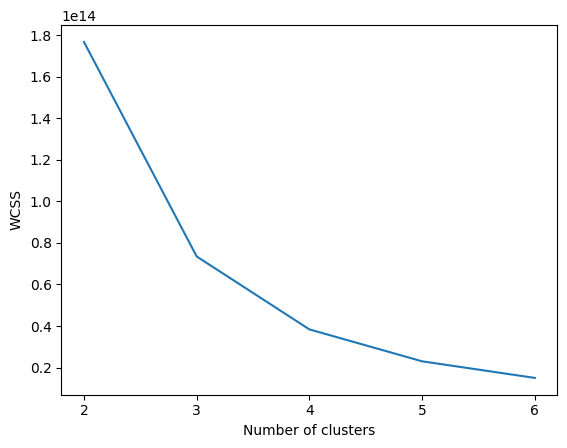

In [35]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_tabels = kmeans.fit_predict(movies_kmeans)

print(cluster_tabels)

wcss = []
max_clusters = 6

for num_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(movies_kmeans)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, max_clusters+1), wcss)
plt.xticks([2,3,4,5,6])
plt.xlabel("Number of clusters")
plt.ylabel('WCSS')
plt.show()

📌 **note:** k = 5

In [36]:
n_clusters=5

##### 🌸 **step 2: provide k-means**

In [37]:
mse_list, models, train_dfs = rec.train_kmeans_and_predict(train_df, test_df, n_clusters=4)

c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

##### 🔮 **step 3: predict for given userId and movieId**

In [76]:
userId = 149
movieId = 4

In [79]:
predicted_rating, predicted_cluster, cluster_mean_ratings = rec.predict_rating_kmeans(userId, movieId, models, train_dfs, movie_data)
predicted_rating = rec.roundRating(predicted_rating)
print(f'Predicted rating for user {userId} and movie {movieId}: {round(predicted_rating,2)}')

Predicted rating for user 149 and movie 4: 3.5


### 04. Rule based recommender system.

##### 🔥 **step 1: apriori algorithm**

Having already generated clusters, we can use the apriori algorithm to generate rules for each cluster.

In [40]:
#example of generated train dataset after kfold
train_dfs[0].head()

,userId,movieId,rating,title,Crime,(no genres listed),Romance,Documentary,Fantasy,Action,...,Mystery,Drama,Comedy,War,Horror,Sci-Fi,Musical,Children,Thriller,cluster
0,149,1,4.0,Toy Story (1995),0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
1,305,1,5.0,Toy Story (1995),0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
3,487,1,4.5,Toy Story (1995),0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
4,897,1,4.0,Toy Story (1995),0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
5,1109,1,5.0,Toy Story (1995),0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1


In [41]:
freq_item = rec.getFrequentItemset(train_dfs)

c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\lidka\AppData\Local\Programs\Python\Pyth

In [42]:
freq_item[0][3]

,support,itemsets
0,0.352456,(Crime)
1,0.053818,(Romance)
2,0.035602,(Fantasy)
3,0.334557,(Action)
4,0.026320,(Film-Noir)
...,...,...
68,0.052444,"(Thriller, Horror, Sci-Fi)"
69,0.020053,"(Action, Thriller, Mystery, Crime)"
70,0.059472,"(Action, Thriller, Drama, Crime)"
71,0.021386,"(Action, Thriller, Comedy, Crime)"


##### 🔥 **step 2: association rules**

In [43]:
rules = rec.getRules(freq_item)

In [44]:
rules[0][2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Crime),(Drama),0.117233,1.0,0.117233,1.0,1.0,0.0,inf,0.0
1,(Romance),(Drama),0.254963,1.0,0.254963,1.0,1.0,0.0,inf,0.0
2,(Fantasy),(Drama),0.051651,1.0,0.051651,1.0,1.0,0.0,inf,0.0
3,(Action),(Drama),0.077196,1.0,0.077196,1.0,1.0,0.0,inf,0.0
4,(Animation),(Drama),0.020784,1.0,0.020784,1.0,1.0,0.0,inf,0.0
5,(Adventure),(Drama),0.055872,1.0,0.055872,1.0,1.0,0.0,inf,0.0
6,(Mystery),(Drama),0.042863,1.0,0.042863,1.0,1.0,0.0,inf,0.0
7,(Comedy),(Drama),0.262312,1.0,0.262312,1.0,1.0,0.0,inf,0.0
8,(War),(Drama),0.079234,1.0,0.079234,1.0,1.0,0.0,inf,0.0
9,(Horror),(Drama),0.021688,1.0,0.021688,1.0,1.0,0.0,inf,0.0


##### 🔥 **step 3: predicting the rating**

In [73]:
userId = 149
movieId = 4
predicted_rating, predicted_cluster, cluster_mean_ratings = rec.predict_rating_kmeans(userId, movieId, models, train_dfs, movie_data)

In [59]:
movie_data

,userId,movieId,rating,title,Crime,(no genres listed),Romance,Documentary,Fantasy,Action,...,Adventure,Mystery,Drama,Comedy,War,Horror,Sci-Fi,Musical,Children,Thriller
0,149,1,4.0,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,305,1,5.0,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,461,1,4.5,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
3,487,1,4.5,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
4,897,1,4.0,Toy Story (1995),0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015497,330687,213211,1.0,In Deep Sleep (2020),0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4015498,330687,226268,4.0,Luxor (2020),0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4015499,330687,265538,4.0,Aurora (2021),0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4015500,330687,280190,3.0,Werner Herzog - Radical Dreamer (2022),0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
im_ru = rec.filterRules(userId, movieId, movie_data, int(predicted_cluster[0]), cluster_mean_ratings, rules)
im_ru

c:\Users\lidka\OneDrive - put.poznan.pl\Pulpit\studia\4 semestr\DM\The Miners - assignment 2\DM-recomendation-system\recommendation.py:308: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rule[1]['antecedents'].issubset(movie[1][1]):
c:\Users\lidka\OneDrive - put.poznan.pl\Pulpit\studia\4 semestr\DM\The Miners - assignment 2\DM-recomendation-system\recommendation.py:309: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  important_rules.append((rule[1], movie[1][0]))


[(antecedents            (Crime)
  consequents           (Comedy)
  antecedent support    0.073149
  consequent support     0.74279
  support               0.064392
  confidence            0.880298
  lift                  1.185122
  leverage              0.010058
  conviction            2.148741
  zhangs_metric         0.168533
  Name: 0, dtype: object,
  1.5),
 (antecedents            (Crime)
  consequents           (Comedy)
  antecedent support    0.073149
  consequent support     0.74279
  support               0.064392
  confidence            0.880298
  lift                  1.185122
  leverage              0.010058
  conviction            2.148741
  zhangs_metric         0.168533
  Name: 0, dtype: object,
  3.0),
 (antecedents            (Crime)
  consequents           (Comedy)
  antecedent support    0.073149
  consequent support     0.74279
  support               0.064392
  confidence            0.880298
  lift                  1.185122
  leverage              0.010058
  convic

In [81]:
rating = rec.predictRatingRules(im_ru)
rating = rec.roundRating(rating)
rating

3

### 05. Accuracy.

- we can use mean square error if we normalize and then denormalize the data
- if not: absolute error

##### **mean-squared error for rule based recommendation system**

In [48]:
## TODO LIDKA

##### **mean-squared error for clustering recommendation system**

In [49]:
## TODO WIKTORIA

##### **Summary:** absolute value error for clustering recomendation system is equal to ...

##### **mean-squared error in general**

In [50]:
## TODO